# FISH ANALYSIS

### 1. SUMMARY

As biologist, one thing that worries me is the problem of biodiversity. To manage the problem of the loss of biodeversity and the high pressure that fish populations suffer due to overexplotation the authomatic recognition of fish species can help to control the populations.

In this project the goal is to train an image classifier to recognize different fish species and predict them by using Convolutional Neural Network.

We wil use a dataset from kaggle(https://www.kaggle.com/crowww/a-large-scale-fish-dataset (1)). This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey for a university-industry collaboration project at Izmir University of Economics, and this workwas published in ASYU 2020.
The dataset includes gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples.

(1) @inproceedings{ulucan2020large,
title={A Large-Scale Dataset for Fish Segmentation and Classification},
author={Ulucan, Oguzhan and Karakaya, Diclehan and Turkan, Mehmet},
booktitle={2020 Innovations in Intelligent Systems and Applications Conference (ASYU)},
pages={1--5},
year={2020},
organization={IEEE}
}

### 2. IMPORTING THE LIBRARIES

In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.applications import *
from PIL import Image
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import warnings

### 3. LOADING AND EXPLORING THE DATA

First of all, lets load the data and take a look how the look like.







In [2]:
direc = Path('C:/Users/NITROPC/Desktop/DATA SCIENCE/CERTIFICACION MACHINE LEARNING/05 - DEEP LEARNING/07 - PROYECTO/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

FilePaths              Labels
0  C:\Users\NITROPC\Desktop\DATA SCIENCE\CERTIFIC...     Hourse Mackerel
1  C:\Users\NITROPC\Desktop\DATA SCIENCE\CERTIFIC...            Sea Bass
2  C:\Users\NITROPC\Desktop\DATA SCIENCE\CERTIFIC...  Striped Red Mullet
3  C:\Users\NITROPC\Desktop\DATA SCIENCE\CERTIFIC...               Trout
4  C:\Users\NITROPC\Desktop\DATA SCIENCE\CERTIFIC...              Shrimp

Now, let´s see the first images from our dataset.

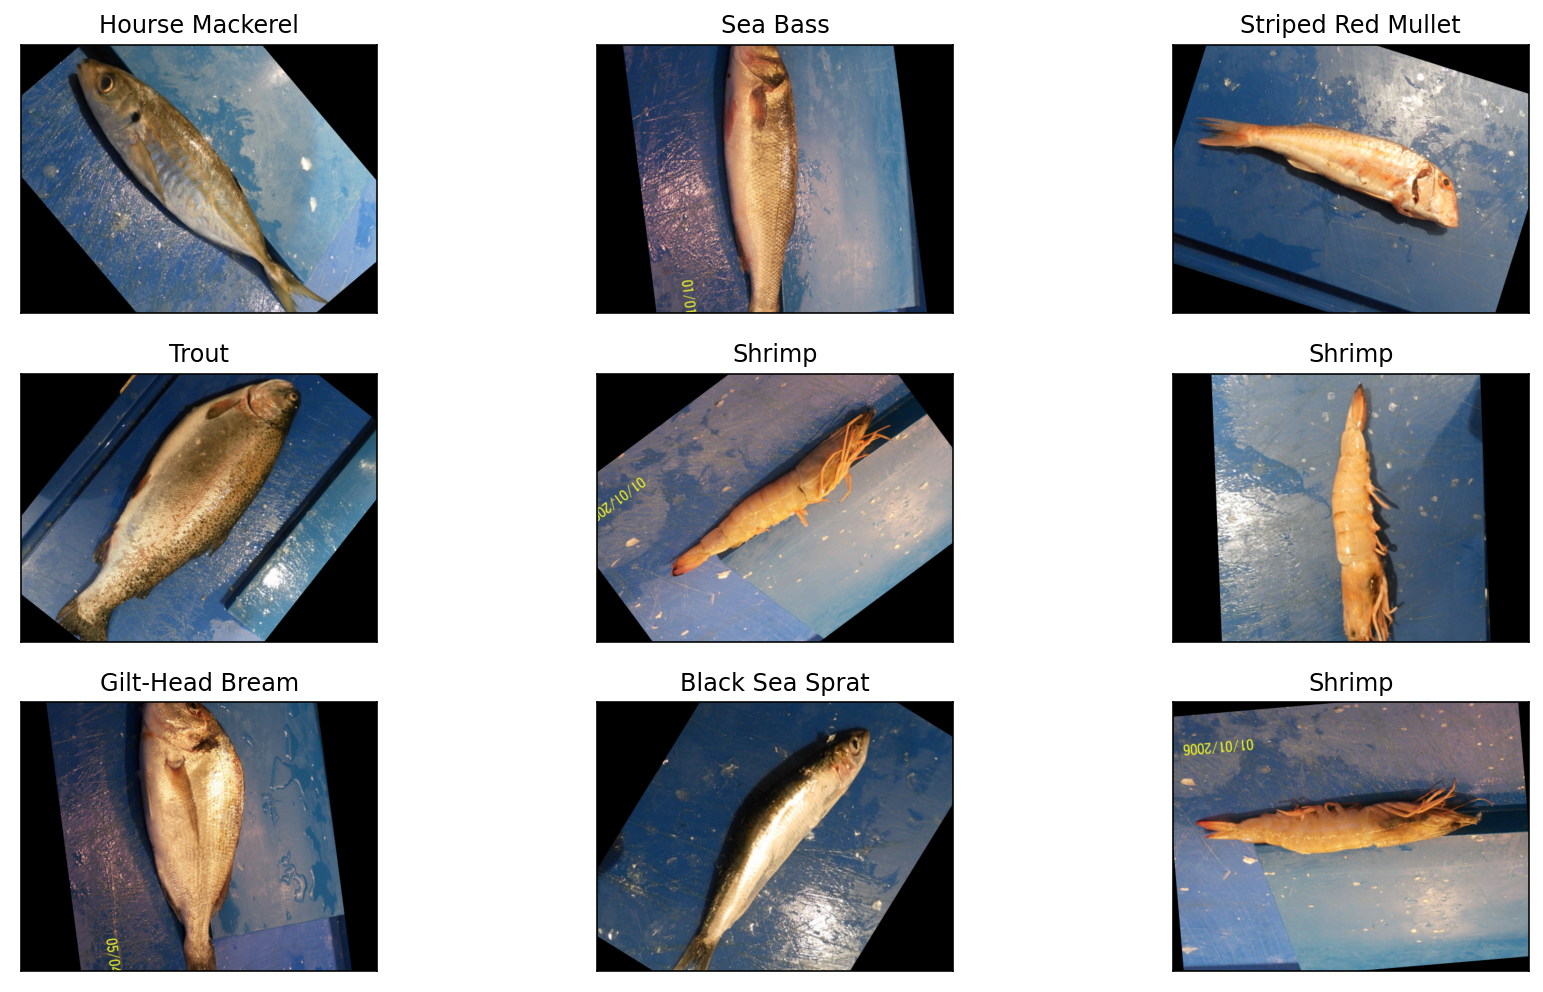

In [3]:
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

Let´s take a look to the shape of our dataframe.

In [4]:
print(f'Count of Rows: {img_df.shape[0]} \nCount of Columns: {img_df.shape[1]}')

Count of Rows: 9000 
Count of Columns: 2


In [5]:
img_df['Labels'].value_counts(ascending=True)

Striped Red Mullet    1000
Red Sea Bream         1000
Black Sea Sprat       1000
Shrimp                1000
Trout                 1000
Hourse Mackerel       1000
Gilt-Head Bream       1000
Red Mullet            1000
Sea Bass              1000
Name: Labels, dtype: int64

### 4. SPLITTING THE DATA

In [6]:
train_df, test_df = train_test_split(img_df, train_size=0.9, shuffle=True, random_state=1)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='FilePaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='FilePaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


#### 5. MODELITATION AND TRAINING
*5.1. MODEL 1: Convolutional Neural Network*

We will create our model with 7 layers, plot the loss and accuracy values achieved during training for the training and validation set and save the trained models as a Keras model.

In [9]:
feature_layers = [tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")]

In [10]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

In [11]:
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
model1_fit = model1.fit(train_images,
                validation_data = val_images,
                epochs = 10)# choose the best weights when early-stopping
 

Epoch 1/10
203/203 [==============================] - 96s 470ms/step - loss: 1.5303 - accuracy: 0.4488 - val_loss: 1.0630 - val_accuracy: 0.6463
Epoch 2/10
203/203 [==============================] - 96s 472ms/step - loss: 0.9532 - accuracy: 0.6667 - val_loss: 0.6709 - val_accuracy: 0.7648
Epoch 3/10
203/203 [==============================] - 104s 511ms/step - loss: 0.6696 - accuracy: 0.7687 - val_loss: 0.4913 - val_accuracy: 0.8377
Epoch 4/10
203/203 [==============================] - 101s 495ms/step - loss: 0.4883 - accuracy: 0.8352 - val_loss: 0.3995 - val_accuracy: 0.8574
Epoch 5/10
203/203 [==============================] - 121s 598ms/step - loss: 0.3607 - accuracy: 0.8806 - val_loss: 0.3042 - val_accuracy: 0.8895
Epoch 6/10
203/203 [==============================] - 113s 555ms/step - loss: 0.2757 - accuracy: 0.9042 - val_loss: 0.2515 - val_accuracy: 0.9130
Epoch 7/10
203/203 [==============================] - 103s 508ms/step - loss: 0.2440 - accuracy: 0.9147 - val_loss: 0.2558 - v

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, None, None, None)  0         
                                                                 
 flatten_1 (Flatten)         (None, None)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               19267712  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 9)                 1

In [15]:
test_accuracy = model1.evaluate(test_images)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

29/29 [==============================] - 10s 334ms/step - loss: 0.1853 - accuracy: 0.9311
Test accuracy is :  93.11110973358154 %


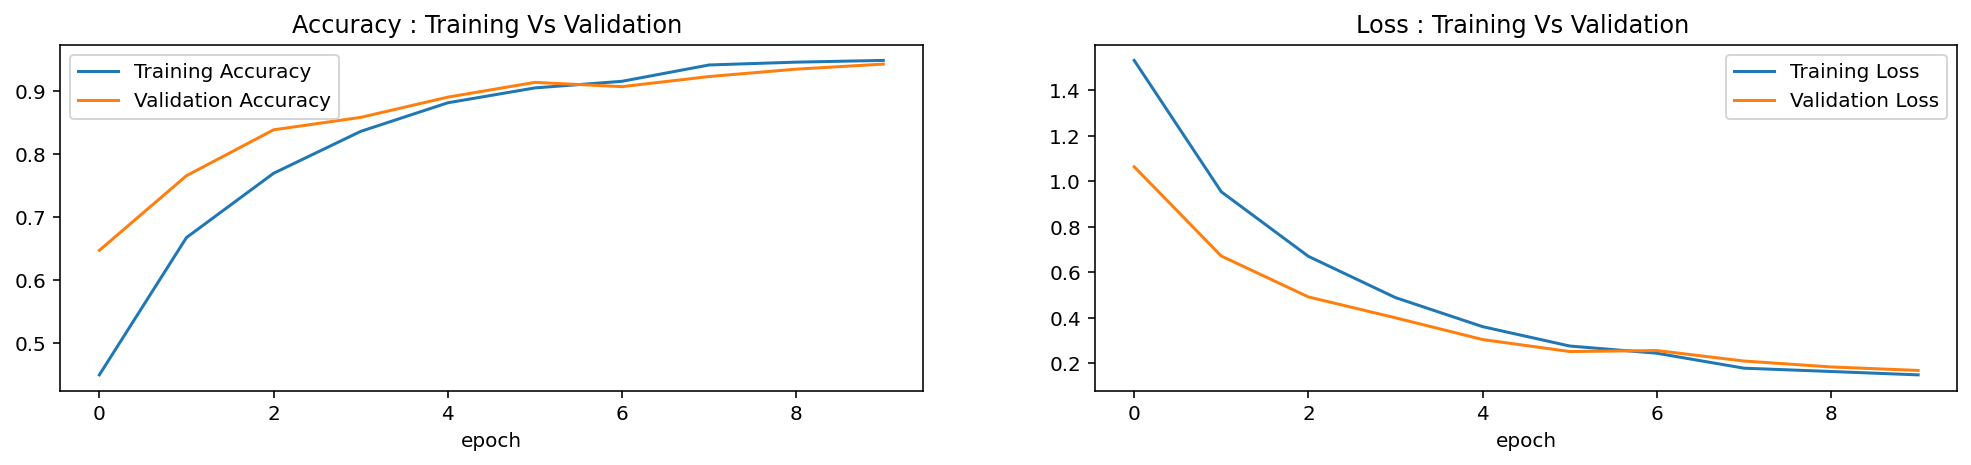

In [16]:
accuracy = model1_fit.history['accuracy']
loss = model1_fit.history['loss']
validation_loss = model1_fit.history['val_loss']
validation_accuracy = model1_fit.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

As we can see, with this model, we get an accuracy of 93.1%, and from the 8th epoch, either loss and accuracy shows no change.

In [17]:
model1.save('model1.h5')

Now, we use our model to predict the images of the test set:

In [18]:
# Predict the label of the test_images
pred = model1.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

Let´s see some predictions with this model:

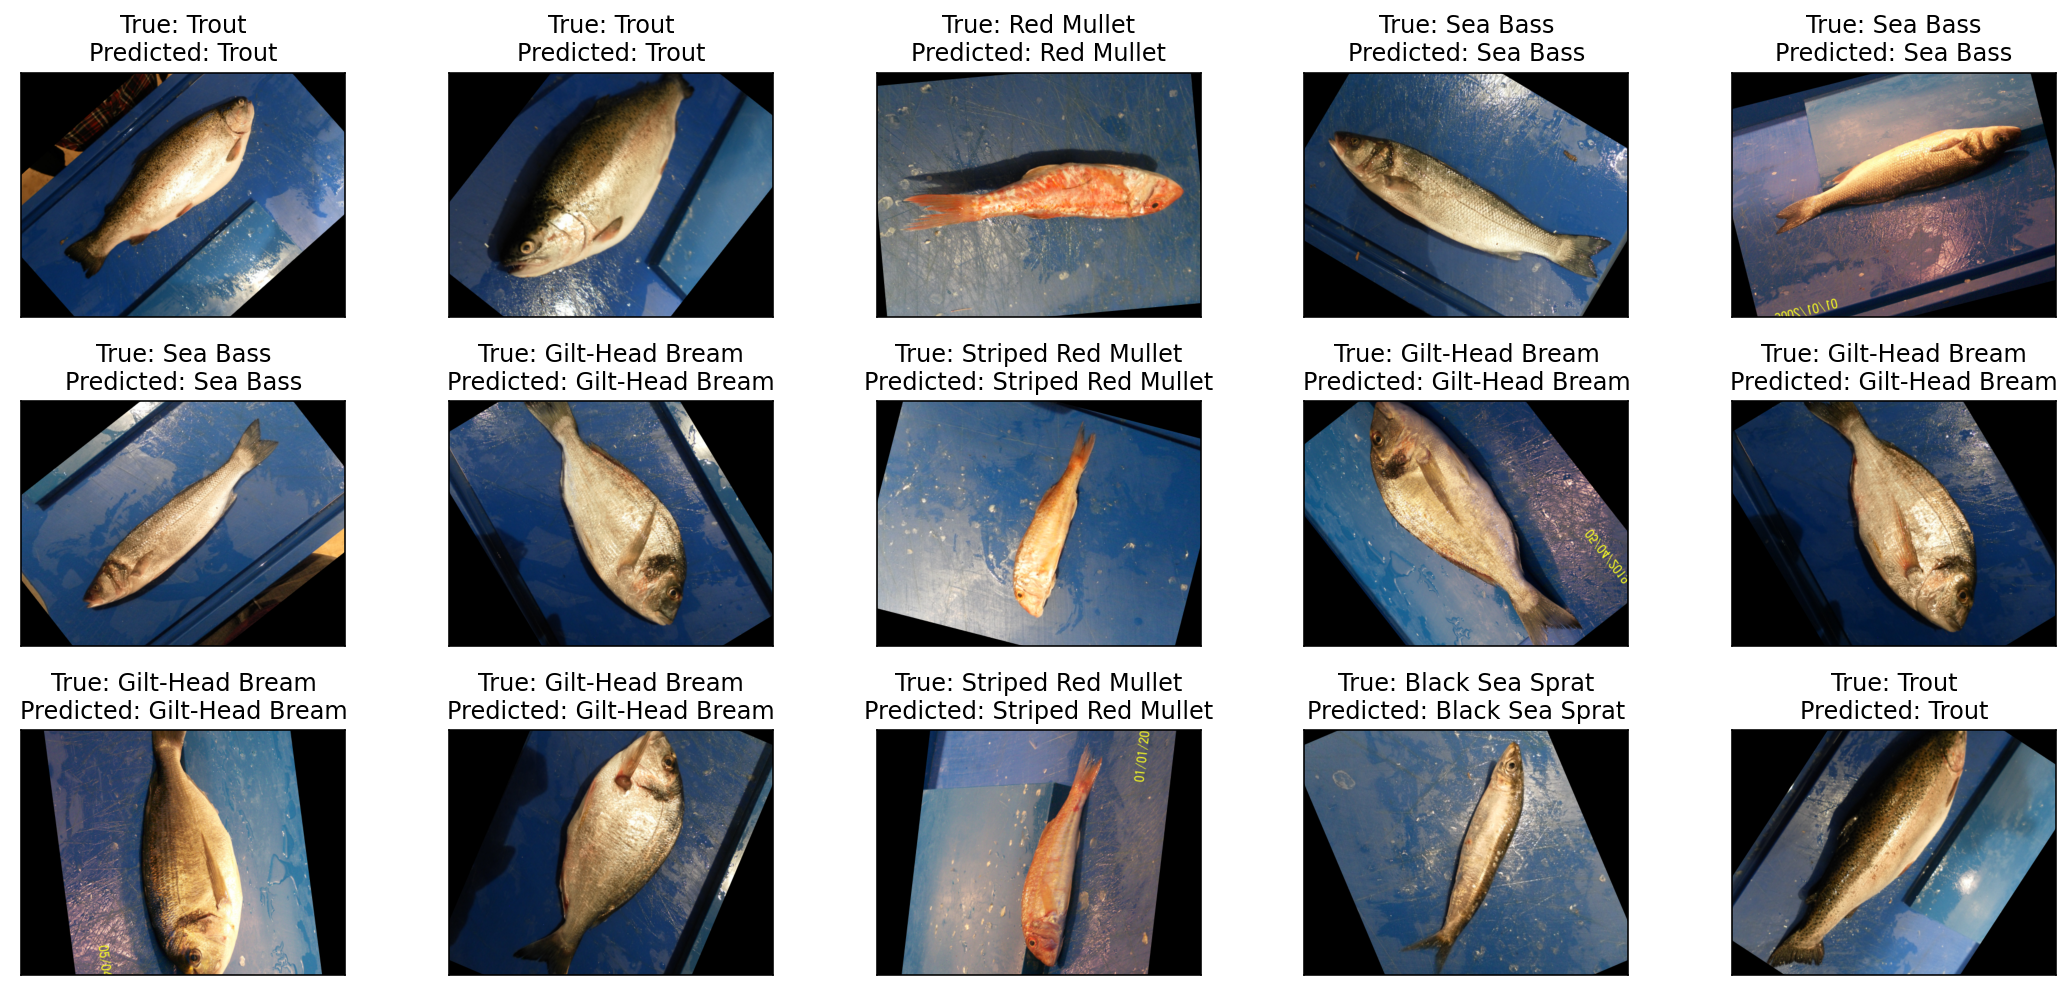

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.FilePaths.iloc[i]))
    ax.set_title(f"True: {test_df.Labels.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

As we can see, all the predictions made with this model are correct!!!

*5.2. MODEL 2: Transfer learning with CNNs*

For model 2 we will load the MobileNet pre-trained network from keras, define a new untrained network and add it to MobileNet as a top layer model and freeze the majority of MobileNet and only train/fine tune the top layers.

In [21]:
model2_base = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

model2_base.trainable = False

In [23]:
inputs = model2_base.input

x = tf.keras.layers.Dense(128, activation='relu')(model2_base.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2_fit = model2.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
203/203 [==============================] - 290s 1s/step - loss: 0.1589 - accuracy: 0.9565 - val_loss: 0.0140 - val_accuracy: 0.9957
Epoch 2/5
203/203 [==============================] - 286s 1s/step - loss: 0.0119 - accuracy: 0.9969 - val_loss: 0.0563 - val_accuracy: 0.9796


In [24]:
test_accuracy = model2.evaluate(test_images)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

29/29 [==============================] - 29s 982ms/step - loss: 0.0165 - accuracy: 0.9956
Test accuracy is :  99.5555579662323 %


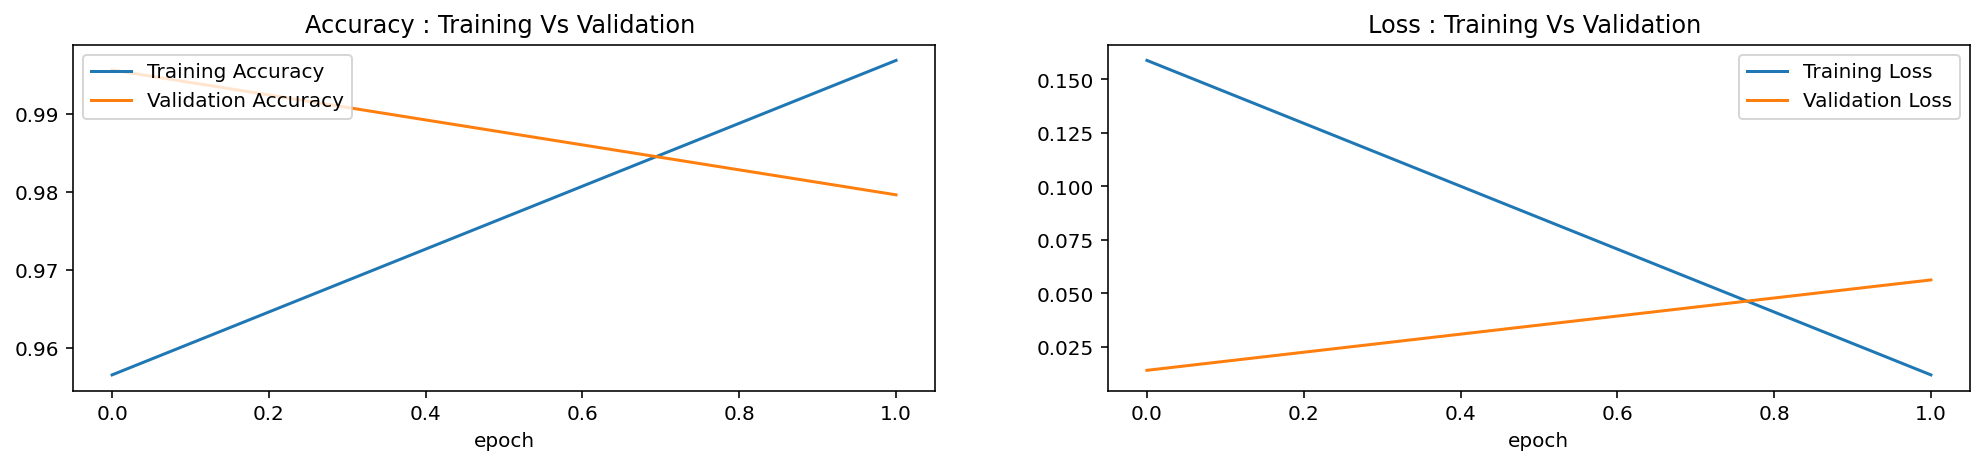

In [26]:
accuracy = model2_fit.history['accuracy']
loss = model2_fit.history['loss']
validation_loss = model2_fit.history['val_loss']
validation_accuracy = model2_fit.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(2), accuracy, label='Training Accuracy')
plt.plot(range(2), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(2), loss, label='Training Loss')
plt.plot(range(2), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

With this model we reach an accuracy of 100% after only 2 epochs!!!!

In [28]:
model2.save('model2.h5')

C:\Users\NITROPC\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Let´s use this model to predict and see some predictions:

In [33]:
# Predict the label of the test_images
pred2 = model2.predict(test_images)
pred2 = np.argmax(pred2,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred2]

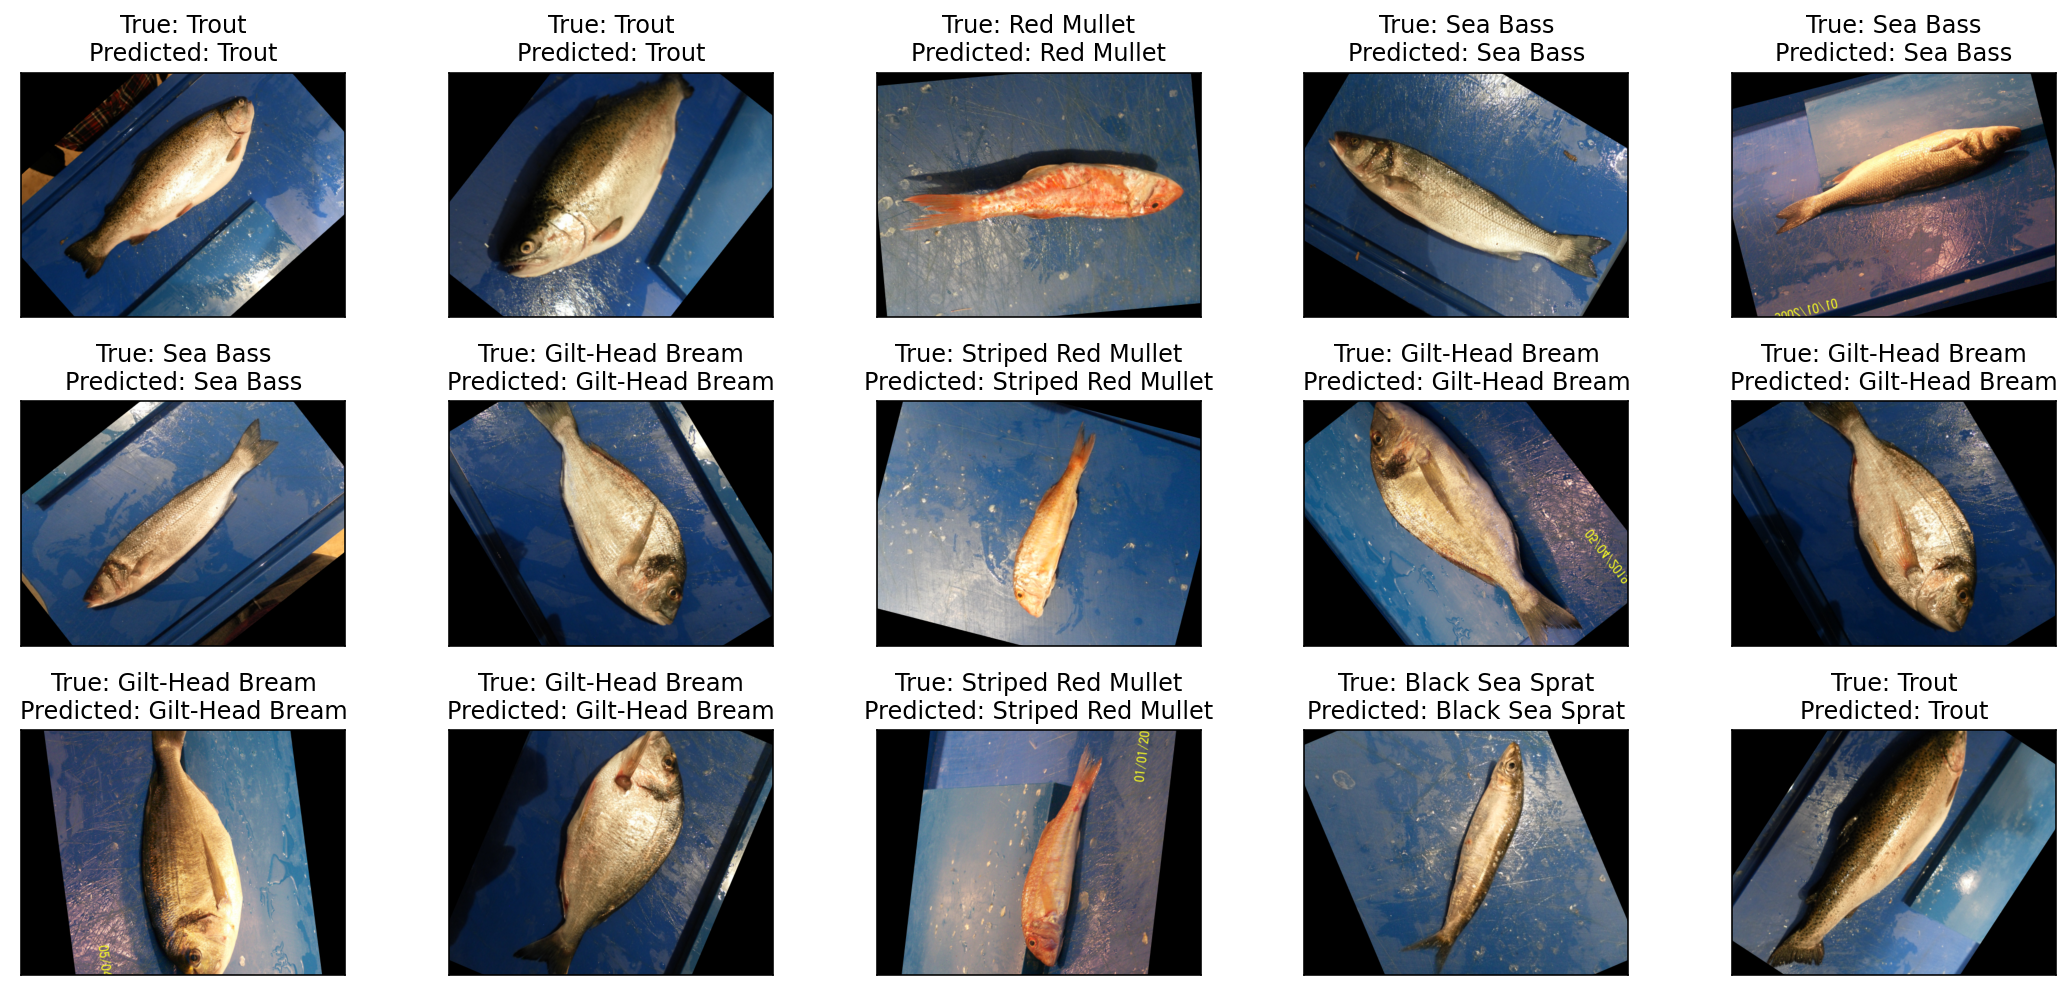

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.FilePaths.iloc[i]))
    ax.set_title(f"True: {test_df.Labels.iloc[i]}\nPredicted: {pred2[i]}")
plt.tight_layout()
plt.show()

As with our first model, we can predict all the species correctly!!!

#### 6. RESULTS

Both models, CNN and transfer learning with CNNs work great and can predict the fish species with almost 100% test accuracy. The train time for CNN with transfer learning is a little bit higher than training our CNN with transfer learning. However we see that using a pre-trained network with transfer learning maked a little difference in terms of accuracy although ~100% accuracy suggests overfitting and therefore testing the model on a larger test batch could reveal a more realistic accuracy. 

#### 7. NEXT STEPS

We could further experiment trying out other pre-trained models with different architecture such as Xception, ResNet or Inception.